# Large Language Models

In [1]:
%pip install --quiet bitsandbytes==0.41.1 transformers==4.39.3 accelerate==0.24.0 sentencepiece==0.1.99 optimum==1.13.2 auto-gptq==0.4.2 torchmetrics peft==0.12.0

import numpy as np
import torch
import torch.nn as nn
import os
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
from IPython.display import clear_output
from tqdm import tqdm
from torchmetrics.functional import accuracy
from torch.optim import AdamW
from peft import PromptTuningConfig, PromptTuningInit, get_peft_model, LoraConfig, TaskType
from transformers import AutoTokenizer, AutoModelForSequenceClassification

sns.set_theme()

os.environ['TOKENIZERS_PARALLELISM'] = 'false'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.0/301.0 kB 13.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.6/92.6 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 30.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.0/261.0 kB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 50.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 28.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.4/296.4 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 869.5/869.5 kB 26.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 45.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.4 MB/s eta 0

## Parameter-Efficient Finetuning

В этом домашнем задании вам предстоит дообучить модель GPT2-small на задачу анализа тональности с помощью различных методов PEFT:

- LoRa – Low-Rank Adaptation
- Prompt tuning
- PEFT + LP-FT

На всякий случай обратим ваше внимание на то, что видеопамяти потребуется довольно много. Советуем использовать Google Colab с GPU T4 - там точно запускается и хватает всего, мы проверили :)

Это датасет fake-and-real-news, который был немного обработан для простоты подачи в модель (мы перемешали классы и обрезали новости до 512 символов, чтобы обучение шло не слишком долго). Нельзя сказать, что простое обрезание новости пошло ей на пользу, но нашей модели это не помешает предсказывать!

https://www.kaggle.com/datasets/clmentbisaillon/fake-and-real-news-dataset?resource=download

Подгрузите данные, используя функцию load_dataset (воспользуйтесь документацией от Hugging Face).


In [2]:
!wget https://raw.githubusercontent.com/aiedu-courses/all_datasets/main/PEFT/train_news.csv
!wget https://raw.githubusercontent.com/aiedu-courses/all_datasets/main/PEFT/test_news.csv

train_dataset = load_dataset('csv', data_files='https://raw.githubusercontent.com/aiedu-courses/all_datasets/main/PEFT/train_news.csv', split='train') # YOUR CODE HERE
valid_dataset = load_dataset('csv', data_files='https://raw.githubusercontent.com/aiedu-courses/all_datasets/main/PEFT/test_news.csv', split='train')  # YOUR CODE HERE

--2024-10-14 13:29:41--  https://raw.githubusercontent.com/aiedu-courses/all_datasets/main/PEFT/train_news.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18982754 (18M) [text/plain]
Saving to: ‘train_news.csv’

train_news.csv      100%[===================>]  18.10M  --.-KB/s    in 0.1s    

2024-10-14 13:29:42 (168 MB/s) - ‘train_news.csv’ saved [18982754/18982754]

--2024-10-14 13:29:42--  https://raw.githubusercontent.com/aiedu-courses/all_datasets/main/PEFT/test_news.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8155

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [3]:
train_dataset[0]

{'title': "Bannon departure tips trade scales in favor of White House 'globalists'",
 'text': 'WASHINGTON (Reuters) - The departure on Friday of Steve Bannon, the White House’s top economic nationalist, will likely tip the trade policy scales in favor of the Trump administration’s “globalist” faction, which could soften the stance toward two of Trump’s favorite targets: China and the North American Free Trade Agreement. But after news that Trump had fired Bannon from his post as chief strategist, trade experts said it may take some time for National Economic Council Chairman Gary Cohn, Treasury Secre',
 'subject': 'politicsNews',
 'date': 'August 18, 2017 ',
 'label': 1}

### Инициализация токенизатора и модели

In [4]:
# Initializing the tokenizer
model_checkpoint = "gpt2"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
tokenizer.add_special_tokens({'pad_token': '[PAD]'})

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

1

In [5]:
class Model(nn.Module):
    def __init__(self, tokenizer, num_classes=2):
        super().__init__()
        self.model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=num_classes)
        self.model.resize_token_embeddings(len(tokenizer))
        self.config = self.model.config

    def forward(self, input_ids=None, attention_mask=None, inputs_embeds=None, *args, **kwargs):
        out = self.model.transformer(
            input_ids=input_ids, inputs_embeds=inputs_embeds, attention_mask=attention_mask
        ).last_hidden_state
        lens = attention_mask.sum(-1).cpu() - 1
        out = self.model.score(out[torch.arange(len(lens)), lens.to(torch.long)])
        return out

    @property
    def device(self):
        return next(self.model.parameters()).device


num_classes = 2
model = Model(tokenizer, num_classes)

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
sum(p.numel() for p in model.parameters())

124442112

Да, 124 с лишним миллиона параметров. Это сильно меньше, чем в современных LLM, но всё равно нельзя сказать, что мало. Здесь мы берём модель поменьше, чтобы уместиться в видеопамять и сравнить эффективные по параметрам методы с обучением полной модели.

### Проверка токенизатора

In [7]:
tokenizer([train_dataset[0]["text"]])

{'input_ids': [[21793, 357, 12637, 8, 532, 383, 12928, 319, 3217, 286, 6542, 19688, 11, 262, 2635, 2097, 447, 247, 82, 1353, 3034, 19848, 11, 481, 1884, 8171, 262, 3292, 2450, 16252, 287, 2661, 286, 262, 1301, 3662, 447, 247, 82, 564, 250, 20541, 396, 447, 251, 17710, 11, 543, 714, 39536, 262, 12046, 3812, 734, 286, 1301, 447, 247, 82, 4004, 6670, 25, 2807, 290, 262, 2258, 1605, 3232, 9601, 12729, 13, 887, 706, 1705, 326, 1301, 550, 6294, 19688, 422, 465, 1281, 355, 4039, 25651, 11, 3292, 6154, 531, 340, 743, 1011, 617, 640, 329, 2351, 11279, 4281, 12787, 10936, 45005, 11, 13419, 1882, 260]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}

In [8]:
batch_size = 32
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size, num_workers=2)
valid_loader = DataLoader(valid_dataset, shuffle=False, batch_size=batch_size, num_workers=2)

In [9]:
print("       0       1")
classes = [t["label"] for t in train_dataset]
print(f"Train: {1 - np.mean(classes):0.3f} {np.mean(classes):0.3f}")

classes = [t["label"] for t in valid_dataset]
print(f"Valid: {1 - np.mean(classes):0.3f} {np.mean(classes):0.3f}")

       0       1
Train: 0.523 0.477
Valid: 0.523 0.477


### Объявление функции для обучения моделей

In [10]:
_ = model.to(device)

In [11]:
def training_loop_fn(model, opt, total_num_iters, eval_freq, train_loader, valid_loader):
    train_loss_history, eval_loss_history = [], []
    train_acc_history, eval_acc_history = [], []
    global_step = 0

    criterion = torch.nn.CrossEntropyLoss()
    model.train()
    while True:
        for batch in tqdm(train_loader):
            tokenized = tokenizer(batch["text"], padding=True, return_tensors='pt')
            for k, v in tokenized.items():
                tokenized[k] = v.to(device)

            with torch.autocast(device_type='cuda', dtype=torch.float16):
                logits = model(tokenized['input_ids'], tokenized['attention_mask'], return_dict=False)
            targets = batch["label"].to(device)
            loss = criterion(logits, targets)

            opt.zero_grad()
            loss.backward()
            opt.step()

            preds = torch.nn.functional.softmax(logits, dim=-1)[:, 1]
            acc = accuracy(preds, targets, task="binary")

            train_loss_history.append((global_step, loss.item()))
            train_acc_history.append((global_step, acc.item()))

            if global_step % eval_freq == 0:
                val_loss, val_acc = evaluate(model, valid_loader)
                eval_loss_history.append((global_step, val_loss))
                eval_acc_history.append((global_step, val_acc))

                model.train()

            if global_step % 250 == 0:
                clear_output(True)

                plt.figure(figsize=(15, 5))

                plt.subplot(121)
                plt.plot(*zip(*train_loss_history), alpha=0.5, label='train_loss')
                if len(eval_loss_history):
                    plt.plot(*zip(*eval_loss_history), color='red', label='eval_loss')
                plt.legend()

                plt.subplot(122)
                plt.plot(*zip(*train_acc_history), alpha=0.5, label='train_acc')
                if len(eval_acc_history):
                    plt.plot(*zip(*eval_acc_history), color='red', label='eval_acc')
                plt.legend()
                plt.show()

            global_step += 1
            if global_step > total_num_iters:
                break
        else:
            continue
        break


@torch.no_grad()
def evaluate(model, dataloader):
    model.eval()
    criterion = torch.nn.CrossEntropyLoss()
    loss_epoch = 0.
    num_epoch = 0.
    preds_list = []
    targets_list = []

    for eval_batch in dataloader:
        tokenized = tokenizer(eval_batch["text"], padding=True, return_tensors='pt')
        for k, v in tokenized.items():
            tokenized[k] = v.to(device)

        with torch.autocast(device_type='cuda', dtype=torch.float16):
            logits = model(tokenized['input_ids'], tokenized['attention_mask'], return_dict=False)

        loss = criterion(logits, eval_batch["label"].to(device))
        num = logits.shape[0]

        loss_epoch += loss.item() * num
        num_epoch += num
        preds = torch.nn.functional.softmax(logits, dim=-1)[:, 1]

        targets_list += eval_batch["label"].tolist()
        preds_list += preds.tolist()

    acc = accuracy(torch.tensor(preds_list).to(device), torch.tensor(targets_list).to(device), task='binary')

    return loss_epoch / num_epoch, acc.item()

### Fine-tuning
В качестве бейзлайна давайте обучим все веса модели. Этот подход может быть вам известен по прошлым курсам. Такой подход, хоть и требовательный к памяти, даёт очень хорошее качество и применяется чаще всего.

Инициализируйте модель (передав ей токенайзер и кол-во классов), поместите её на GPU. В качестве оптимизатора возьмите AdamW с learning rate 2e-6.

In [ ]:
# YOUR CODE HERE
num_classes = 2

model = Model(tokenizer, num_classes)
model.to(device)

optimizer = AdamW(model.parameters(), lr=2e-6)
# YOUR CODE HERE

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


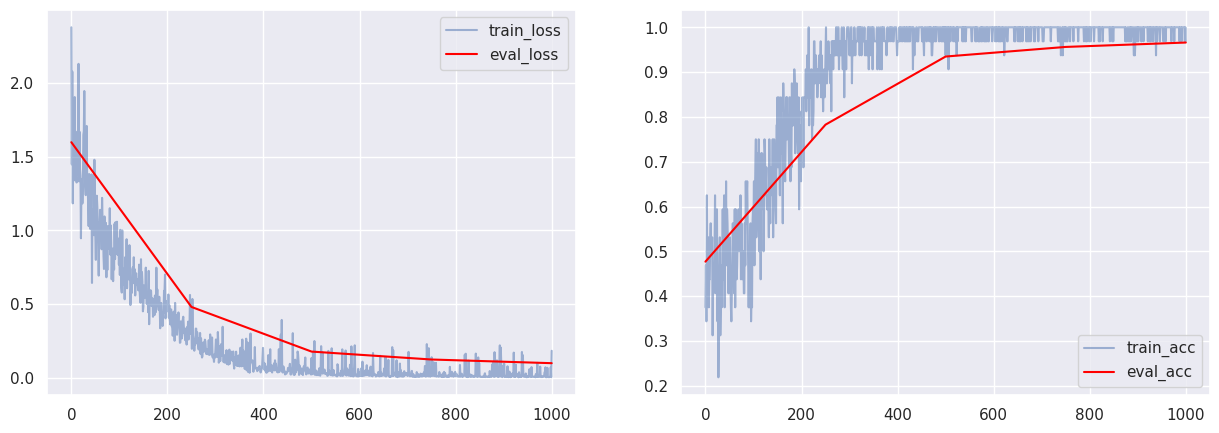

  2%|▏         | 17/983 [00:57<54:55,  3.41s/it]

CPU times: user 9min 50s, sys: 4.04 s, total: 9min 54s
Wall time: 10min 7s


In [ ]:
%%time
training_loop_fn(model, optimizer, 1000, 250, train_loader, valid_loader)

In [ ]:
val_loss, val_acc = evaluate(model, valid_loader)
print(f'val loss: {val_loss}')
print(f'val accuracy: {val_acc}')

val loss: 0.09823876191884744
val accuracy: 0.9659985303878784


### Linear Probing

Другой способ, который вы скорее всего видели - обучение только последних (или последнего) линейных слоев сети. Давайте попробуем и его:

- Инициализируйте модель заново как делали ранее (для чистоты эксперимента мы хотим неизмененные веса)
- Возьмите оптимизатор AdamW, но в этот раз передайте ему только параметры model.model.score и lr 1e-4

In [ ]:
# YOUR CODE HERE
num_classes = 2

model = Model(tokenizer, num_classes)
model.to(device)

optimizer = AdamW(model.model.score.parameters(), lr=1e-4)
# YOUR CODE HERE

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


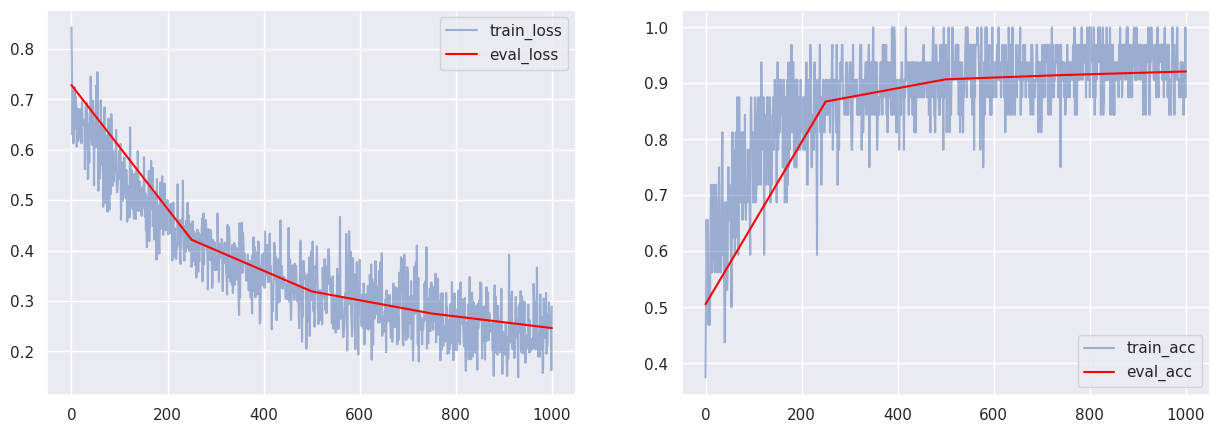

  2%|▏         | 17/983 [00:57<54:45,  3.40s/it]

CPU times: user 9min 18s, sys: 3.33 s, total: 9min 21s
Wall time: 9min 37s


In [ ]:
%%time
training_loop_fn(model, optimizer, 1000, 250, train_loader, valid_loader)

In [ ]:
val_loss, val_acc = evaluate(model, valid_loader)
print(f'val loss: {val_loss}')
print(f'val accuracy: {val_acc}')

val loss: 0.2462073197963066
val accuracy: 0.9211581349372864


### LoRa

Давайте, наконец, перейдём к методам, эффективным по параметрам :)

В оригинальной статье авторы предлагают учить только матрицы $W_K$ и $W_V$ в слоях внимания трансформера и последний линейный слой. Однако мы добавим к ним еще матрицу $W_Q$, потому что в архитектуре GPT все три матрицы считаются с помощью одного слоя, и разделять их было бы слишком неудобно.

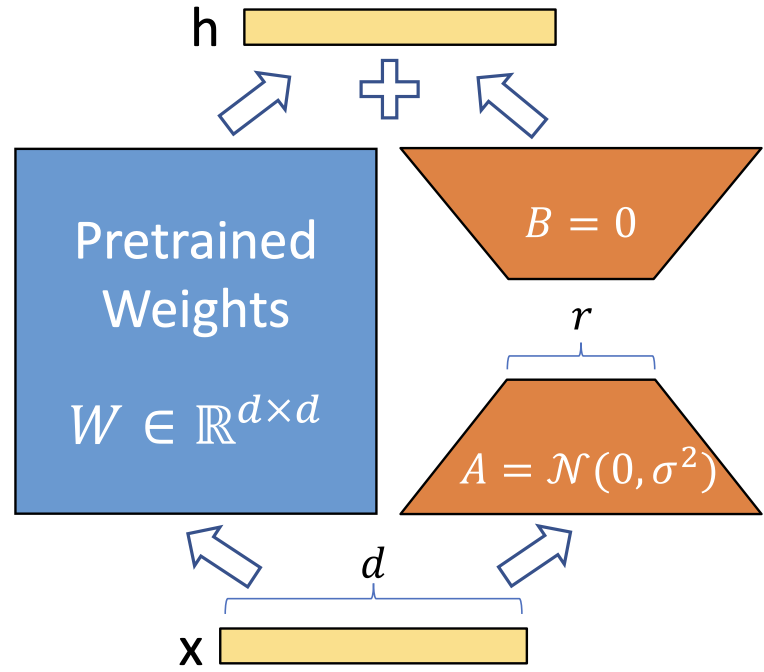

Для реализации Parameter-Efficient Fine-Tuning мы будем пользоваться библиотекой `peft` (семейство huggingface). В ней реализованы многие наиболее удачные способы дообучения моделей. Полный список можно найти [тут](https://github.com/huggingface/peft).

Самый важный параметр этой модели – ранг матриц $A$ и $B$ ($r$). Его увеличение дает больше степеней свободы в настройке добавки $AB$, повышая вместе с этим количество обучаемых параметров.

Возьмите LoraConfig со следующими настройками:

- task_type=TaskType.SEQ_CLS, ведь мы обучаем классификацию последовательностей
- inference_mode=False
- r=8, это как раз ранг матриц
- lora_dropout=0.1
- target_modules=["c_attn"]

Дальше при помощи get_peft_model (посмотрите какие параметры нужно туда передать) соберите lora_model. Не забудьте переложить модель на GPU!

In [ ]:
# YOUR CODE HERE
peft_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    inference_mode=False,
    r=8,
    lora_dropout=0.1,
    target_modules=["c_attn"]
)

num_classes = 2
model = Model(tokenizer, num_classes)
lora_model = get_peft_model(model, peft_config)
lora_model.to(device)
# YOUR CODE HERE

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): Model(
      (model): GPT2ForSequenceClassification(
        (transformer): GPT2Model(
          (wte): Embedding(50258, 768)
          (wpe): Embedding(1024, 768)
          (drop): Dropout(p=0.1, inplace=False)
          (h): ModuleList(
            (0-11): 12 x GPT2Block(
              (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
              (attn): GPT2Attention(
                (c_attn): lora.Linear(
                  (base_layer): Conv1D()
                  (lora_dropout): ModuleDict(
                    (default): Dropout(p=0.1, inplace=False)
                  )
                  (lora_A): ModuleDict(
                    (default): Linear(in_features=768, out_features=8, bias=False)
                  )
                  (lora_B): ModuleDict(
                    (default): Linear(in_features=8, out_features=2304, bias=False)
                  )
                  (lora_embedding_A): Para

Посмотрим сколько параметров обучаем теперь. Можете проверить, верно ли вы выполнили задание, введя ответ с количеством обучаемых параметров на Stepik.

In [ ]:
sum(p.numel() for p in lora_model.parameters() if p.requires_grad)

296448

Можно сделать это ещё вот так:

In [ ]:
lora_model.print_trainable_parameters()

trainable params: 296,448 || all params: 124,738,560 || trainable%: 0.2377


Здесь уже не будем вас просить написать оптимизатор и напишем его за вас:

In [ ]:
optimizer = AdamW(lora_model.parameters(), lr=1e-4)

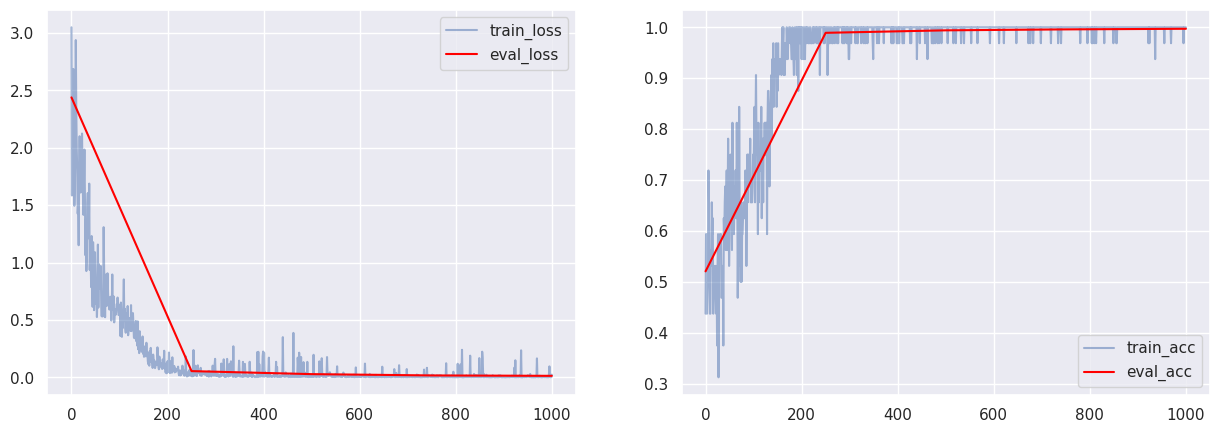

  2%|▏         | 17/983 [01:01<57:47,  3.59s/it]

CPU times: user 9min 8s, sys: 3.72 s, total: 9min 12s
Wall time: 9min 24s


In [ ]:
%%time
training_loop_fn(lora_model, optimizer, 1000, 250, train_loader, valid_loader)

In [ ]:
val_loss, val_acc = evaluate(lora_model, valid_loader)
print(f'val loss: {val_loss}')
print(f'val accuracy: {val_acc}')

val loss: 0.01292382391099144
val accuracy: 0.9971047043800354


In [ ]:
torch.save(lora_model.base_model.model.model.score.state_dict(), 'lora_head.pt')

### Prompt Tuning

Посмотрим на следующий метод :)

Prompt Tuning – наиболее архитектурно-зависимый способ дообучения моделей, так как основан на наблюдении о том, что большие языковые модели способны решать задачи в zero-shot и few-shot парадигме (то есть опираясь только на входной промпт и текст, для которого нужно выдать ответ). Для моделей, которые могут работать в таком формате Prompt Tuning предлагает не выбирать промпт руками, а обучить его. Таким образом, этот метод лучше всего будет работать с моделями вида GPT и хуже всего с BERT. Вместе с промптом дополнительно доучивается голова.

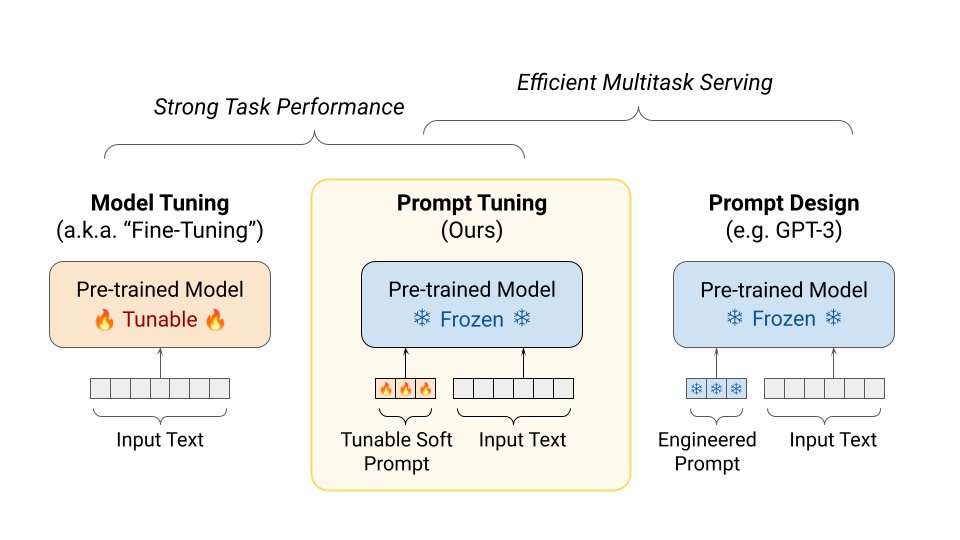<!-- <img src="attachment:60eae4f0-193d-4108-b9c2-8d37e54f791e.png" alt="drawing" width="800"/> -->


При настройке промпта можно варьировать его длину, а также способ инициализации. Тут работает правило: чем больше датасет для дообучения, тем длинее можно брать промпты. Если датасет маленький, то длиный промпт не сможет обучиться.

In [ ]:
len(tokenizer("Predict if this news article is real or fake")['input_ids'])

10

In [ ]:
init = {PromptTuningInit.TEXT: "Predict if this news article is real or fake"}

Возьмите PromptTuningConfig с параметрами:
 - task_type, inference_mode - аналогично прошлым
 - num_virtual_tokens=12
 - num_layers возьмите количество слоев из конфигурации модели (посмотрите как они там внесены)
 - token_dim возьмите n_embd из конфигурации модели, n
 - num_attention_heads количество голов из конфигурации модели,
 - prompt_tuning_init=init

 Далее воспользуйтесь уже знакомой вам функцией get_peft_model

In [ ]:
# YOUR CODE HERE
config = model.config
peft_config = PromptTuningConfig(
    task_type=TaskType.SEQ_CLS,
    inference_mode=False,
    num_virtual_tokens=12,
    num_layers=config.num_hidden_layers,
    token_dim=config.n_embd,
    num_attention_heads=config.num_attention_heads,
    prompt_tuning_init=init
)

model = Model(tokenizer, num_classes)
model.to(device)
pt_model = get_peft_model(model, peft_config)

pt_model.print_trainable_parameters()
# YOUR CODE HERE

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 10,752 || all params: 124,452,864 || trainable%: 0.0086


In [ ]:
optimizer = AdamW(pt_model.parameters(), lr=1e-4)

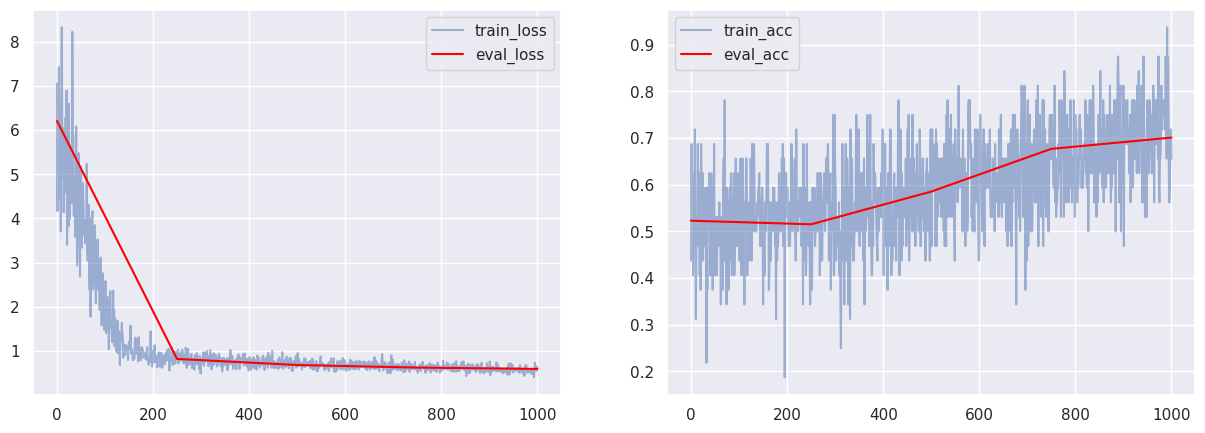

  2%|▏         | 17/983 [01:03<59:49,  3.72s/it]

CPU times: user 9min 32s, sys: 3.86 s, total: 9min 36s
Wall time: 9min 50s


In [ ]:
%%time
training_loop_fn(pt_model, optimizer, 1000, 250, train_loader, valid_loader)

In [ ]:
val_loss, val_accuracy = evaluate(pt_model, valid_loader)
print(f'val loss: {val_loss}')
print(f'val acc: {val_accuracy}')

val loss: 0.5942290738678545
val acc: 0.7011878490447998


### LP-FT

А что если смешать Linear Probing и Fine-tuning? :)

**Шаг 1:** загрузите при помощи `torch.load` сохраненные результаты обучения lora_head

**Шаг 2:** инициализируйте последний слой (score) модели `model` весами из lora_head

**Шаг 3:** обучите всю модель (все ее веса), передав необходимые параметры в оптимизатор

In [ ]:
#YOUR CODE HERE
chkpt = torch.load('lora_head.pt', weights_only=True)
chkpt.keys()
#YOUR CODE HERE

odict_keys(['original_module.weight', 'modules_to_save.default.weight'])

In [ ]:
#YOUR CODE HERE
model = Model(tokenizer, num_classes).to(device)
model.model.score.weight.data = chkpt['original_module.weight'].clone()
#YOUR CODE FOR INITIALIZATION HERE

optimizer = AdamW(model.parameters(), lr=2e-6)
#YOUR CODE HERE

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


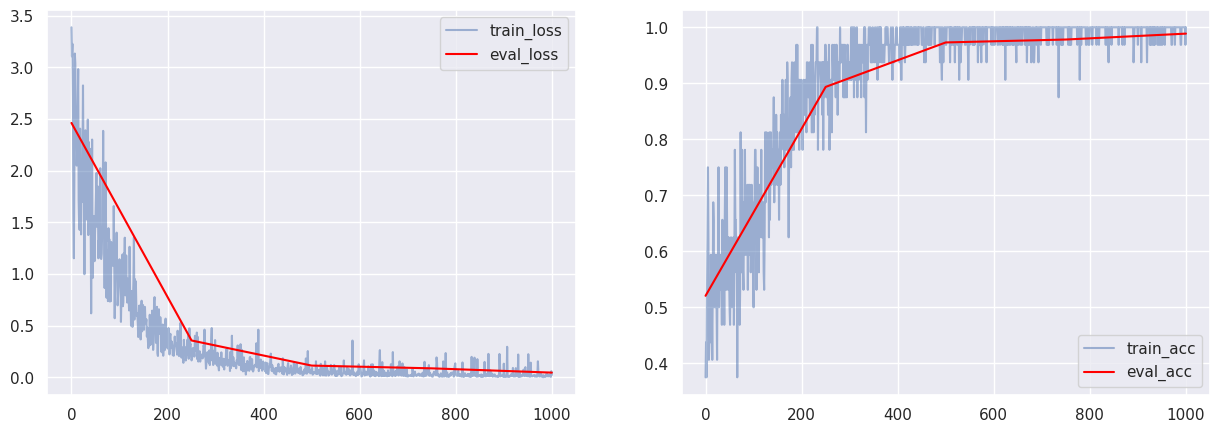

  2%|▏         | 17/983 [01:00<57:19,  3.56s/it]

CPU times: user 9min 44s, sys: 4.2 s, total: 9min 49s
Wall time: 10min 14s


In [ ]:
%%time
training_loop_fn(model, optimizer, 1000, 250, train_loader, valid_loader)

In [ ]:
val_loss, val_acc = evaluate(model, valid_loader)
print(f'val loss: {val_loss}')
print(f'val accuracy: {val_acc}')

val loss: 0.046163315125191395
val accuracy: 0.988715648651123


### Testing the model

In [ ]:
@torch.no_grad()
def predict(text, target=0):
    tokenized = tokenizer(text, return_tensors='pt')
    for k, v in tokenized.items():
        tokenized[k] = v.to(device)

    logits = model(tokenized['input_ids'], tokenized['attention_mask'], return_dict=False)
    probs = torch.nn.functional.softmax(logits, dim=-1)

    predicted_class_id = int(torch.argmax(logits, dim=-1))
    print(f"text: {text}")
    print(f"target: {target}, pred: {predicted_class_id}")
    print("probs:", probs.cpu().numpy())

В ячейке ниже выведите для любых 10 примеров из валидационного датасета:
* текст
* правильный ответ (label)
* прогноз модели

In [ ]:
# YOUR CODE HERE
num_samples = 10
examples = valid_dataset.shuffle(seed=42).select(range(num_samples))

for example in examples:
    text = example['text']
    target = example['label']
    predict(text, target)
# YOUR CODE HERE

text: It seems that Fox News  repeated decisions to shower of Donald Trump with adoration and excuses has gotten to now-former Fox News host Megyn Kelly. That s right  now former. According to the New York Times, Kelly will be jumping ship to NBC where she will hist a daytime news and discussion program, anchor her own weekend show, and be a part of the network s special political coverage.This may or may not come as a shock to Fox, whose ousted former chairman Roger Ailes sexually harassed Kelly for about a deca
target: 0, pred: 0
probs: [[0.99767    0.00232998]]
text: WASHINGTON (Reuters) - The United States has warned Saudi Arabia that anger in Congress over the humanitarian situation in Yemen could constrain U.S.  assistance, as it pushed Riyadh to allow great access for humanitarian aid, a senior U.S. official said on Friday.   We wanted to be very clear with Saudi officials that the political environment here could constrain us if steps aren t taken to ease humanitarian condition

# Задача-эксперимент

Мы решили проверить, кто самый сильный промпт инженер. Попробуйте выбить как можно более высокое качество при помощи Prompt Tuning! Вы можете изменять любые параметры конфига и сам промпт. Удачи!

In [ ]:
init = {PromptTuningInit.TEXT: "Classify whether the following news article is real or fake"}

In [ ]:
config = model.config
peft_config = PromptTuningConfig(
    task_type=TaskType.SEQ_CLS,
    inference_mode=False,
    num_virtual_tokens=12,
    num_layers=config.num_hidden_layers,
    token_dim=config.n_embd,
    num_attention_heads=config.num_attention_heads,
    prompt_tuning_init=init
)

model = Model(tokenizer, num_classes)
model.to(device)
pt_model = get_peft_model(model, peft_config)

pt_model.print_trainable_parameters()

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 10,752 || all params: 124,452,864 || trainable%: 0.0086


In [ ]:
optimizer = AdamW(pt_model.parameters(), lr=1e-4)

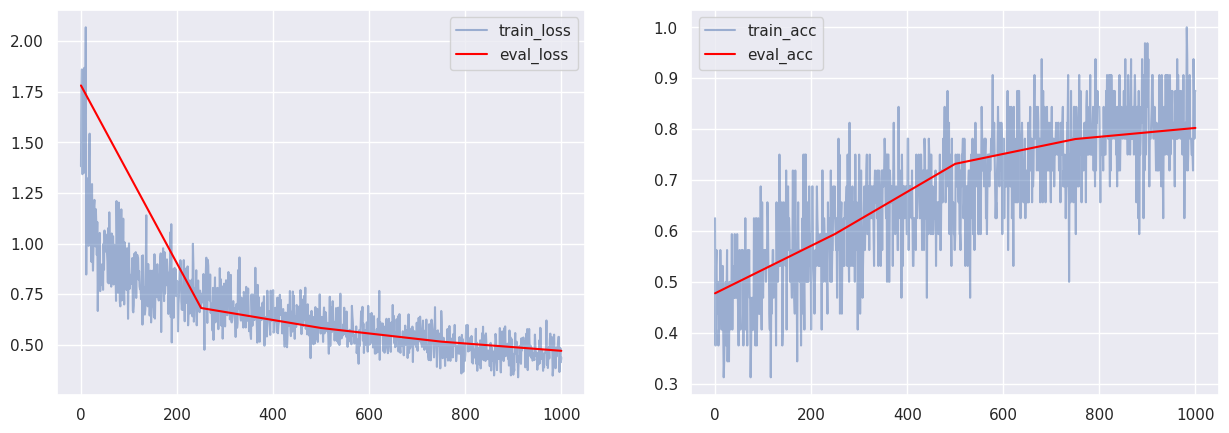

  2%|▏         | 17/983 [01:03<59:46,  3.71s/it]

CPU times: user 9min 33s, sys: 4.03 s, total: 9min 37s
Wall time: 9min 49s


In [ ]:
%%time
training_loop_fn(pt_model, optimizer, 1000, 250, train_loader, valid_loader)

In [ ]:
val_loss, val_accuracy = evaluate(pt_model, valid_loader)
print(f'val loss: {val_loss}')
print(f'val acc: {val_accuracy}')

val loss: 0.4702342735012992
val acc: 0.8023014068603516


Удалось побить accuracy по сравнению с accuracy с заданным в ноутбуке промптом на 10% (с 0.7 до 0.8) только изменением промпта!

Попробуем уменьшить количество виртуальных токенов с 12 до 8 и посмотрим на результат:

In [ ]:
init = {PromptTuningInit.TEXT: "Classify whether the following news article is real or fake"}

In [ ]:
config = model.config
peft_config = PromptTuningConfig(
    task_type=TaskType.SEQ_CLS,
    inference_mode=False,
    num_virtual_tokens=8,
    num_layers=config.num_hidden_layers,
    token_dim=config.n_embd,
    num_attention_heads=config.num_attention_heads,
    prompt_tuning_init=init
)

model = Model(tokenizer, num_classes)
model.to(device)
pt_model = get_peft_model(model, peft_config)

pt_model.print_trainable_parameters()

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 7,680 || all params: 124,449,792 || trainable%: 0.0062


In [ ]:
optimizer = AdamW(pt_model.parameters(), lr=1e-4)

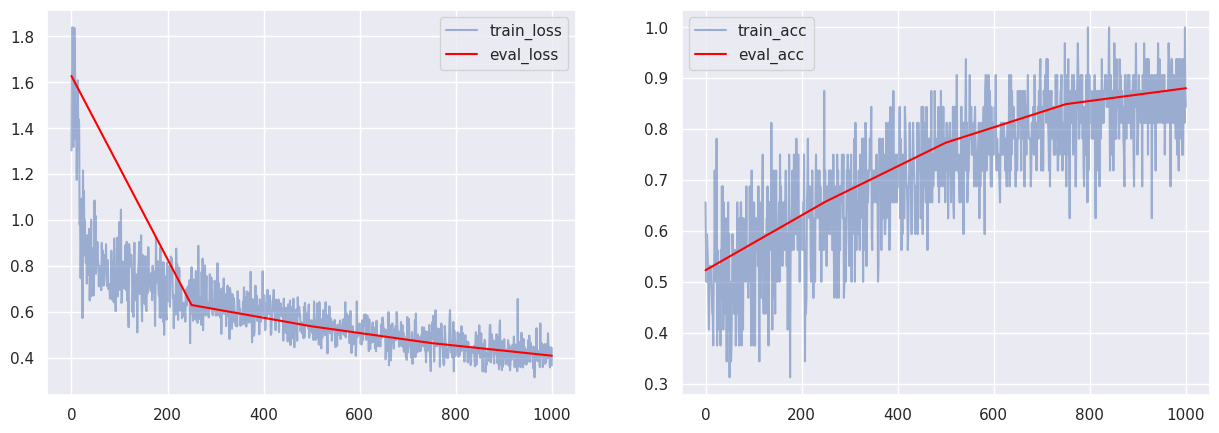

  2%|▏         | 17/983 [01:03<59:48,  3.72s/it]

CPU times: user 8min 54s, sys: 3.13 s, total: 8min 58s
Wall time: 9min 19s


In [ ]:
%%time
training_loop_fn(pt_model, optimizer, 1000, 250, train_loader, valid_loader)

In [ ]:
val_loss, val_accuracy = evaluate(pt_model, valid_loader)
print(f'val loss: {val_loss}')
print(f'val acc: {val_accuracy}')

val loss: 0.4102554649800483
val acc: 0.8803266286849976


Accuracy увеличилась с 0.8 до 0.88 при уменьшении num_virtual_tokens в конфиге. Попробуем уменьшить их количество до 4:

In [ ]:
init = {PromptTuningInit.TEXT: "Classify whether the following news article is real or fake"}

In [ ]:
config = model.config
peft_config = PromptTuningConfig(
    task_type=TaskType.SEQ_CLS,
    inference_mode=False,
    num_virtual_tokens=4,
    num_layers=config.num_hidden_layers,
    token_dim=config.n_embd,
    num_attention_heads=config.num_attention_heads,
    prompt_tuning_init=init
)

model = Model(tokenizer, num_classes)
model.to(device)
pt_model = get_peft_model(model, peft_config)

pt_model.print_trainable_parameters()

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 4,608 || all params: 124,446,720 || trainable%: 0.0037


In [ ]:
optimizer = AdamW(pt_model.parameters(), lr=1e-4)

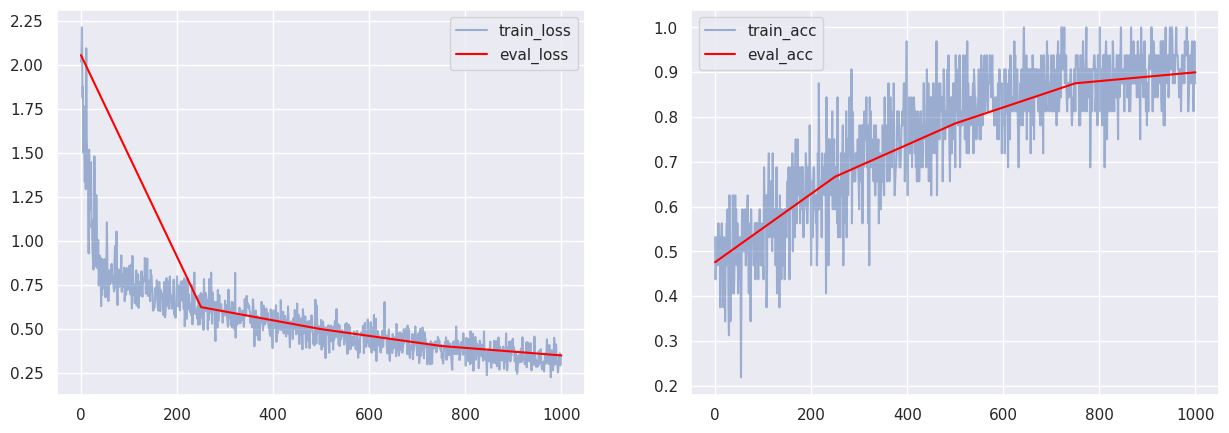

  2%|▏         | 17/983 [00:57<54:04,  3.36s/it]

CPU times: user 8min 42s, sys: 3.22 s, total: 8min 45s
Wall time: 8min 57s


In [ ]:
%%time
training_loop_fn(pt_model, optimizer, 1000, 250, train_loader, valid_loader)

In [ ]:
val_loss, val_accuracy = evaluate(pt_model, valid_loader)
print(f'val loss: {val_loss}')
print(f'val acc: {val_accuracy}')

val loss: 0.3484479036168337
val acc: 0.8995545506477356


Как можно заметить, уменьшением виртуальных токенов до 4 можно добиться accuracy ≈ 90%. В конце попробуем изменить промпт, а именно написать его более подробно:

In [12]:
init = {PromptTuningInit.TEXT: "Evaluate the truthfulness of the following news article. If it is based on verified facts, label it 'Real'. If it contains falsehoods or misleading information, label it 'Fake':"}

In [13]:
config = model.config
peft_config = PromptTuningConfig(
    task_type=TaskType.SEQ_CLS,
    inference_mode=False,
    num_virtual_tokens=4,
    num_layers=config.num_hidden_layers,
    token_dim=config.n_embd,
    num_attention_heads=config.num_attention_heads,
    prompt_tuning_init=init
)

model = Model(tokenizer, num_classes)
model.to(device)
pt_model = get_peft_model(model, peft_config)

pt_model.print_trainable_parameters()

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 4,608 || all params: 124,446,720 || trainable%: 0.0037


In [14]:
optimizer = AdamW(pt_model.parameters(), lr=1e-4)

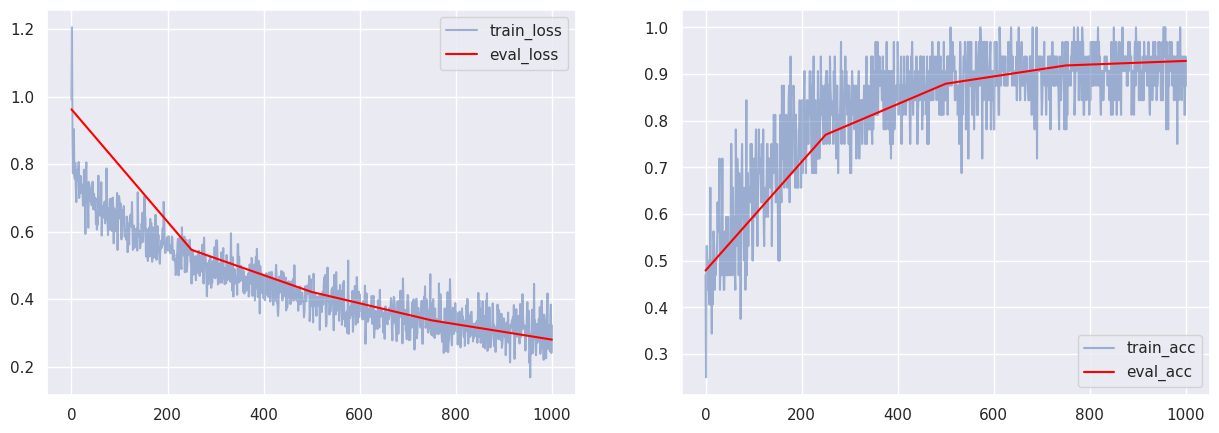

  2%|▏         | 17/983 [00:58<55:27,  3.44s/it]

CPU times: user 8min 45s, sys: 3.85 s, total: 8min 49s
Wall time: 9min 19s


In [15]:
%%time
training_loop_fn(pt_model, optimizer, 1000, 250, train_loader, valid_loader)

In [16]:
val_loss, val_accuracy = evaluate(pt_model, valid_loader)
print(f'val loss: {val_loss}')
print(f'val acc: {val_accuracy}')

val loss: 0.2802227606486637
val acc: 0.9279881119728088


Изменив промпт (написав более подробно с уточнениями) и параметр конфига num_virtual_tokens=4, получаем accuracy ≈ 92,8% что превосходит accuracy в методе Linear Probing, равную ≈ 92,1%.

# Выводы

Напишите ниже текстом выводы из проведенных экспериментов. Есть ли наиболее удачный для данного датасета метод эффективного обучения? Какой метод - самый неудачный в этой задаче?

- Fine Tuning: 96,6%;
- Linear Probing: 92,1%;
- LoRa: 99,7%;
- LP-FT: 98,9%;
- Prompt Tuning: 70,1%;
- Prompt Tuning (best accuracy): 92,8%.

Эксперименты показывают, что лучшим методом оказался LoRa - 99,7% accuracy. Наихудшим оказался Prompt Tuning, показавший всего 70,1%.

Fine-tuning всех весов модели показал хороший результат (96.6%).

Linear probing продемонстрировал средние результаты (92.1%). Данный метод эффективен по времени и ресурсам, так как обучается только последний слой, однако остальная часть модели остаётся замороженной и не адаптируется к специфике задачи. Это сказалось на качестве предсказаний.

Метод LoRA продемонстрировал высокую эффективность (99.7%). Этот метод позволяет дообучать только малую часть параметров (матрицы в слоях внимания), что делает его крайне эффективным по ресурсам и ,по итогу, лучшим по качеству.

Комбинация Linear Probing и Fine-Tuning дала отличный результат (98.9%), однако, по эффективности уступает LoRA.

Prompt Tuning дал наихудший результат по сравнению с другими методами (70.1%). В нашем случае, оказалось необходимым дорабатывать конфиг и промпт для получения лучшего качества. Как минимум, уменьшением количества виртуальных токенов и написания более подробного длинного промпта получилось достичь точности в 92,8%, что превосходит метод Linear Probing (92,1%).
